In [1]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

# Recursion Depth
sys.setrecursionlimit(1000000000)

# Intialize tqdm to always use the notebook progress bar
import tqdm

tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml

import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import collections

plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git
import aneurysm_utils.evaluation as evaluation

# Project utils

from mpl_toolkits.mplot3d import Axes3D
import aneurysm_utils
from aneurysm_utils import evaluation, training,preprocessing,postprocessing
%matplotlib inline

/group/cake/leo/.venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def unify_alternativ(image, patch_size,most_common_shape):
    """
    image: numpy.array
          shape is (number_of_patches,h,w,d) , number_of_patches,heigth,width,depth
    patch_size: int
            e.g. 64
    most_common_shape: tuple
                for example(139,139,120)

    Return

    image: np.array

          unified and unpatch image, shape (most_common_shape)


    """
    number_of_patches,heigth,width,depth = image.shape

    dim = np.array(most_common_shape)# size of the image
    n_patches = np.ceil(dim/patch_size).astype(int) # calculates the number of patches for each dim, to cover all voxel at least once in form e.g[3,3,2]
    rest  = n_patches * patch_size%dim ## calculates number of entries for each dimension which overlapp, means for example n_patches = 18 and 64 we have rest = 53
    
    h,w,d = most_common_shape

    ## initializing empty array for the unified image
    unified_image =  np.zeros([h,w,d])

    counter = 0 ## counter for patches
    

    
    for i in range(n_patches[0]):

        if i == n_patches[0]-1: ## only the last cube is an overlapped cube
          start_x = i*patch_size-rest[0]
          stop_x= (i+1)* patch_size-rest[0]

        else:    
          start_x = i*patch_size
          stop_x = (i+1)* patch_size



        for j in range(n_patches[1]):
            if j == n_patches[1]-1: ## only the last cube is an overlapped cube
                start_y = j*patch_size-rest[1]
                stop_y= (j+1)* patch_size-rest[1]

            else:    
                start_y = j*patch_size
                stop_y = (j+1)* patch_size

            for k in range(n_patches[2]):
                if k == n_patches[2]-1: 
                    start_z = k*patch_size-rest[2]
                    stop_z = (k+1)* patch_size-rest[2]

                else:    
                    start_z = k*patch_size
                    stop_z = (k+1)* patch_size


              ##maximum between channel one or two, probably not necessary
              #max_class = np.maximum(image[n,0,:,:,:],image[n,1,:,:,:])

              ###includes overlapping case
              #unified_image[start_x:stop_x,start_y:stop_y,start_z:stop_z] = np.maximum(unified_image[start_x:stop_x,start_y:stop_y,start_z:stop_z],max_class)
                unified_image[start_x:stop_x,start_y:stop_y,start_z:stop_z] = np.maximum(unified_image[start_x:stop_x,start_y:stop_y,start_z:stop_z],image[counter,:,:,:])
                
                counter+=1## next patch
                
                if (counter==18):
                    break;
    
    return unified_image


In [3]:
def patch_unifier_alternativ(list_patches,size_test_set,most_common_shape,patch_size):
  """
  list_patches: list
                containing predictions from the evaluations, length should be number_of_patches x length_test_set
                each element should have the form (h,w,d)
  size_test_set: int

  most_common_shape: tuple
                most_common shape from the original input images before patchifying
  
  patch_size: int



  Return:

  unified_images: list
                contains the unpatched images 
                each element has the shape:(most_common_shape) 

  """
  
  dim = np.array(most_common_shape)
  n_patches = np.ceil(dim/patch_size).astype(int)# output is number of patches per dimension

  number_of_patches = np.prod(n_patches)# number of patches overall

  h,w,d = most_common_shape
  
  unified_images = []
  assert (len(list_patches)/(number_of_patches))== size_test_set
  

  ##output list: each element has the form (number_of_patches,n_classes,h,w,d)
  images = np.split(np.array(list_patches),size_test_set)  

  for n in range(size_test_set):
        
        unified_images.append(unify_alternativ(images[n],patch_size,most_common_shape))
  assert len(unified_images) == size_test_set
  return unified_images

In [2]:
case_list_shuffled=["A130_R","A118","A120","A115","A133","A073","A072","A077","A064"]
labels=[]

for cases in case_list_shuffled:
    file_path=f"../../../../../data/training/{cases}_labeledMasks.nii.gz"
    labels.append(nib.load(file_path).get_fdata())

In [33]:
#predictions = np.load("../ramona/preds_attention_ramona_2021-07-12-17-17-25_mask-pytorch-attention-unet_Attention_Unet_Attention_Unet_1560.pt.npy",allow_pickle=True)
#predictions = np.load("../ramona/preds_attention_ramona_2021-07-13-15-03-01_mask-pytorch-attention-unet_Attention_Unet_Attention_Unet_4960.pt.npy",allow_pickle=True)
#predictions = np.load("../markus/preds_unet_fs2_6240.npy",allow_pickle=True)
predictions =np.load("pointnet_2.npy")

In [ ]:
### dimension 1: two entries first one are masks, second on the logits

converter = map(lambda x: x[0], predictions)
preds = list(converter)
probabilites=list(map(lambda x: x[1], predictions))
#most_commen_shape=

In [ ]:
del predictions

np.histogram(np.array(probabilites)[np.array(preds)>0])

for n in range(len(predicitons))
    t = torch.from_numpy(probabilites[n])
    probabilites[n] = torch.sigmoid(t).numpy()

for n in range(len(probabilites)):
    probabilites[n][preds[n]>0] =  np.where(probabilites[n][preds[n]>0]>4,1,0)

In [8]:
## inputs:   list_patches,size_test_set,most_common_shape,patch_size

#most_commen_shape with 1.2 voxdim is 116,116,100
most_common_shape=(116,116,100)
uni = patch_unifier_alternativ(preds,9,most_common_shape,64)
uni_probs= patch_unifier_alternativ(probabilites,9,most_common_shape,64)


Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


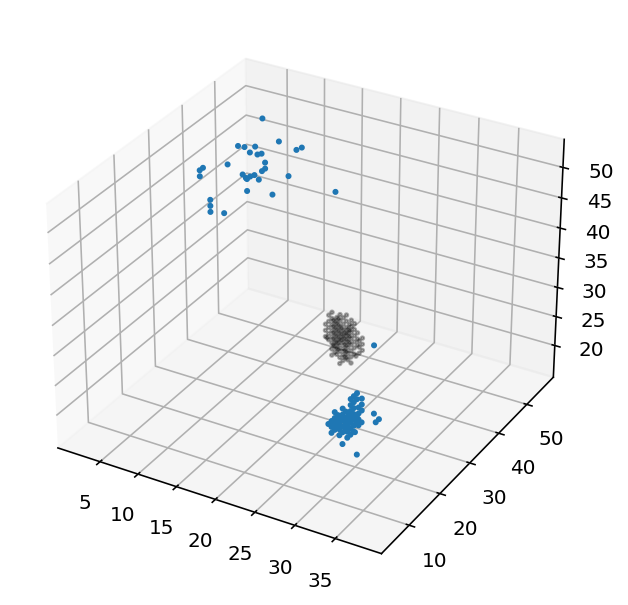

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [49]:
for count,(image,label) in enumerate(zip(predictions,labels)):
    if count==2:
        fig = plt.figure()
        ax = Axes3D(fig)
    
        label = postprocessing.resample([label],(70,70,100))[0]
        
        evaluation.draw_mask_3d(label,ax=ax,c="black",alpha=0.3)
        evaluation.draw_mask_3d(image,ax=ax,zorder=10,alpha=1.0,markersize=4)
        #ax.set_xlim([0,116])
        #ax.set_ylim([0,116])
        #ax.set_zlim([0,110])

for image in labels:
    print(np.unique(image))

for image in uni_probs:
    fig = plt.figure()
    ax = Axes3D(fig)
    evaluation.draw_mask_3d(image,ax=ax)

In [7]:
if "workspace" in os.getcwd():
    ROOT = "/workspace"
elif "/group/cake" in os.getcwd(): 
    ROOT = "/group/cake"

In [8]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder=ROOT)
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /group/cake
 - Project folder: /group/cake/our-git-project
 - Datasets folder: /data/training
 - Models folder: /group/cake/our-git-project/models
 - Experiments folder: /group/cake/our-git-project/experiments


In [43]:
postprocess_dict={
    "dbscan":True,
    #"patch_size":64,
    "resample_voxel_dim":(2,2,2),
    "eps":3,
    "num_imgs":9,
    "min_samples":3,
    "size_smallest":5,
    "size_biggest":200000,
    "resample":True,
    "remove_border_candidates":True
    
}

In [39]:
processed = postprocessing.postprocess(env,predictions,postprocess_dict)

[INFO] Postprocessing: DBSCAN...
[INFO] Postprocessing: Removing noise...
[INFO] Postprocessing: Removing border candidates...
[INFO] Postprocessing: Resample to Size(256, 256, 220)


In [44]:
for image in processed:
    print(np.unique(image))

[0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]


In [45]:
postprocessing.create_task_one_json(processed,case_list_shuffled,processing_times=None,path="../../cada-challenge-master/cada_detection/test/reference.json",path_datasets="../../../../../data/training/")

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


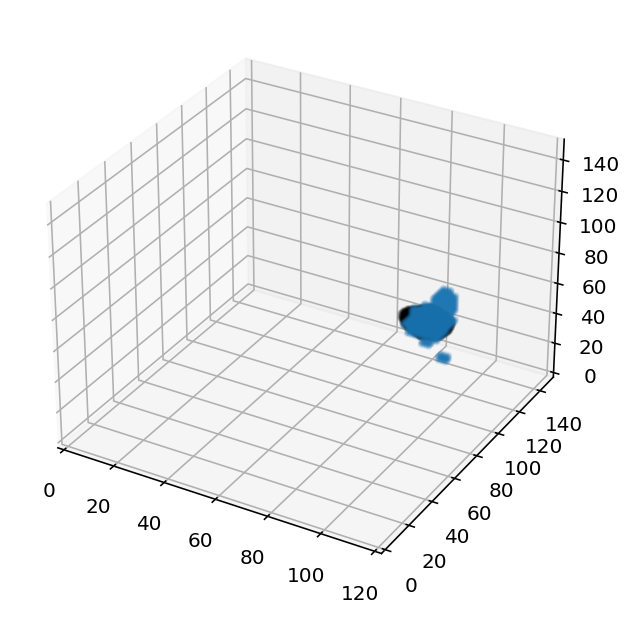

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [51]:
candidates = postprocessing.bounding_boxes(processed)
for count,(image,label) in enumerate(zip(processed,labels)):
    if count==2:
        fig = plt.figure()
        ax = Axes3D(fig)
        
        
        evaluation.draw_mask_3d(label,ax=ax,c="black",alpha=0.1)
        evaluation.draw_mask_3d(image,ax=ax,zorder=10,alpha=0.1,markersize=4)
        #evaluation.draw_bounding_box(candidates[count]["candidates"],ax=ax)#,aneurysm_array=image,vessel_array=labels,c="black")
        ax.set_xlim([0,120])
        ax.set_ylim([0,150])
        ax.set_zlim([0,150])
   

for image in labels:
    evaluation.draw_mask_3d(image)